In [37]:
#!/usr/bin/python

import sys
import pickle
import pandas as pd
import numpy
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# features_list is a list of my selected features
# all_features is a list for exploration
#features_list = ['poi', 'bonus', 'expenses', 'bon_plus_expenses', 'bon_sal_ratio', \
#                'to_msg_ratio', 'from_msg_ratio']

features_list = ['poi', 'bon_plus_expenses', 'exercised_stock_options', 
                'total_payments']
all_features = ['poi', 'salary', 'bonus', 'long_term_incentive', \
                'deferred_income', 'expenses', 'total_payments', \
                'exercised_stock_options', 'restricted_stock', 'other', 'to_messages', \
                'email_address', 'from_poi_to_this_person', 'from_messages', \
                'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_msg_ratio', \
                'from_msg_ratio', 'bon_plus_expenses', 'bon_sal_ratio'] 


### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame.from_records(list(data_dict.values()))
employees = pd.Series(list(data_dict.keys()))

# set the index of df to be the employees series:
df.set_index(employees, inplace=True)

In [3]:
# Find how many missing values are in all features
for feature in all_features:
    try:
        print "Number of missing values in " + str(feature) + ": " + str(df[feature].value_counts(dropna=False)[0])
    except:
        print "Created feature: ", str(feature)

Number of missing values in poi: 128
Number of missing values in salary: 51
Number of missing values in bonus: 64
Number of missing values in long_term_incentive: 80
Number of missing values in deferred_income: 97
Number of missing values in expenses: 51
Number of missing values in total_payments: 21
Number of missing values in exercised_stock_options: 44
Number of missing values in restricted_stock: 36
Number of missing values in other: 53
Number of missing values in to_messages: 60
Number of missing values in email_address: 35
Number of missing values in from_poi_to_this_person: 12
Number of missing values in from_messages: 60
Number of missing values in from_this_person_to_poi: 20
Number of missing values in shared_receipt_with_poi: 60
Created feature:  to_msg_ratio
Created feature:  from_msg_ratio
Created feature:  bon_plus_expenses
Created feature:  bon_sal_ratio


In [4]:
# Create another working dataframe to make new features 
df_new = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).copy()

In [5]:
# from_msg_ratio is ratio messages received from poi to total messages received
df_new['to_msg_ratio'] = df_new.from_this_person_to_poi.divide(df_new.to_messages, axis = 'index')

# create to_msg_ratio by dividing from_this_person_to_poi from to_messages
df_new['from_msg_ratio'] = df_new.from_poi_to_this_person.divide(df_new.from_messages, axis = 'index')

# create a new feature by adding expenses and bonus together
df_new['bon_plus_expenses'] = df_new['bonus'].add(df_new['expenses'], axis = 'index')
# new feature of bonus to salary ratio

df_new['bon_sal_ratio'] = df_new['bonus'].divide(df_new['salary'], axis = 'index')
# new feature of bonus to expenses ratio

In [6]:
# Fill NaN with 0 where operations created NaN in some rows
df_new.fillna(0, inplace = True)

In [7]:
# after you create features, the column names will be your new features
# create a list of column names:
new_features_list = df_new.columns.values
new_features_list

array(['bonus', 'deferral_payments', 'deferred_income', 'director_fees',
       'email_address', 'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person',
       'from_this_person_to_poi', 'loan_advances', 'long_term_incentive',
       'other', 'poi', 'restricted_stock', 'restricted_stock_deferred',
       'salary', 'shared_receipt_with_poi', 'to_messages',
       'total_payments', 'total_stock_value', 'to_msg_ratio',
       'from_msg_ratio', 'bon_plus_expenses', 'bon_sal_ratio'], dtype=object)

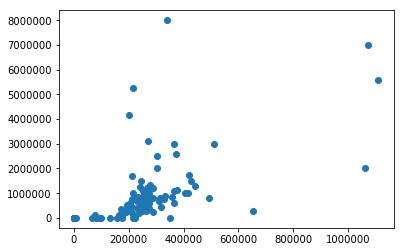

In [39]:
### Task 2: Remove outliers

# plot salary vs bonus as first step of outlier detection, visually

%matplotlib inline

x = df_new['salary']
y = df_new['bonus']

plt.scatter(x, y)

In [ ]:
# From the mini project, we have to remove the one outlier called "TOTAL" as 
# a spreadsheet quirk
df_new.drop(['TOTAL'], inplace=True)

In [9]:
# Once outliers are removed, data values should be scaled
# Email ratios definitely don't match bonus and expenses scales
df_new_scaled = (df_new- df_new.min()) / (df_new.max() - df_new.min())
# Some of these may have created NaNs in the dataset
# Fill the NaN with 0 again
df_new_scaled.fillna(0, inplace = True)

In [10]:
# create a dictionary from the dataframe
df_dict = df_new_scaled.to_dict('index')

In [11]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = df_dict

In [36]:
len(my_dataset)

145

In [12]:
### Extract features and labels from dataset for local testing
# Created one function for exploration then another for use after feature selection
exploration_data = featureFormat(my_dataset, all_features, sort_keys = True)
labels_exploration, features_exploration = targetFeatureSplit(exploration_data)

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [13]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

In [14]:
# First one tried is RandomForestClassifier
rfc_exploration = RandomForestClassifier()
rfc_exploration = rfc_exploration.fit(features_exploration, labels_exploration)

In [15]:
# Also trying a decision tree classifier because tree classifiers make sense here
dc_exploration = DecisionTreeClassifier()
dc_exploration= dc_exploration.fit(features_exploration, labels_exploration)

In [16]:
# This function appends the feature and according importance value from tree
# classifier to a list to view more neatly
rfc_impt = []
dc_impt = []

def input_impt(impt_list, features_list, impts):
    for i in range(len(impts)):
        impt_list.append( (features_list[i], impts[i]) )
    
    impt_list.sort(key = lambda tup: tup[1], reverse = True)
    
    return impt_list

In [17]:
# Call previous function to append and sort feature importances 
input_impt(rfc_impt, all_features[1:], rfc_exploration.feature_importances_)
input_impt(dc_impt, all_features[1:], dc_exploration.feature_importances_)

[('bon_plus_expenses', 0.29502004557122657),
 ('expenses', 0.17125124189984753),
 ('restricted_stock', 0.12049154306372167),
 ('exercised_stock_options', 0.1178661654327829),
 ('total_payments', 0.091078358794894232),
 ('from_poi_to_this_person', 0.084572761738116065),
 ('from_messages', 0.054368203974503197),
 ('other', 0.042286380869058032),
 ('to_msg_ratio', 0.023065298655849813),
 ('salary', 0.0),
 ('bonus', 0.0),
 ('long_term_incentive', 0.0),
 ('deferred_income', 0.0),
 ('to_messages', 0.0),
 ('email_address', 0.0),
 ('from_this_person_to_poi', 0.0),
 ('shared_receipt_with_poi', 0.0),
 ('from_msg_ratio', 0.0),
 ('bon_sal_ratio', 0.0)]

In [18]:
print "RandomForestClassifier importances values: "
for item in rfc_impt:
    print item[0] + " : " + str(item[1])

RandomForestClassifier importances values: 
exercised_stock_options : 0.137323918798
other : 0.112516095663
bonus : 0.0982748826566
expenses : 0.0890666308604
bon_plus_expenses : 0.0841239772867
total_payments : 0.0717691964246
deferred_income : 0.0672532280963
restricted_stock : 0.055536255978
bon_sal_ratio : 0.0522939702564
to_msg_ratio : 0.0415089448161
long_term_incentive : 0.0375786951324
to_messages : 0.0352396407225
shared_receipt_with_poi : 0.0333794354743
from_msg_ratio : 0.0288571766329
from_poi_to_this_person : 0.0174527260382
from_messages : 0.0149151624512
from_this_person_to_poi : 0.0130673648905
salary : 0.00984269782225
email_address : 0.0


In [19]:
print "DecisionTreeClassifier importances values: "
for item in dc_impt:
    print item[0] + " : " + str(item[1])

DecisionTreeClassifier importances values: 
bon_plus_expenses : 0.295020045571
expenses : 0.1712512419
restricted_stock : 0.120491543064
exercised_stock_options : 0.117866165433
total_payments : 0.0910783587949
from_poi_to_this_person : 0.0845727617381
from_messages : 0.0543682039745
other : 0.0422863808691
to_msg_ratio : 0.0230652986558
salary : 0.0
bonus : 0.0
long_term_incentive : 0.0
deferred_income : 0.0
to_messages : 0.0
email_address : 0.0
from_this_person_to_poi : 0.0
shared_receipt_with_poi : 0.0
from_msg_ratio : 0.0
bon_sal_ratio : 0.0


In [20]:
# Assign to new classifiers after choosing features

rfc = rfc_exploration.fit(features, labels)
dc = dc_exploration.fit(features, labels)

In [21]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info:
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [22]:
# straified cv for parameters, 100 fold, and shuffled
best_cv = StratifiedShuffleSplit(n_splits = 100, random_state=42) 

In [23]:
# random_state is to bring consistency to results
# results to best_params_ were inconsistent before adding random_state
# If you uncomment to run these lines of code, it may take a while.
# Added start and end times to see how long this all takes because
# this exhaustive method has been taking forever. 
# Both CV settings are set to optimize for f1 to get better precision and recall
# It took me 78 minutes to run rfc and about 3 to run decisiontreeclassifier

#start_gridcv_rfc = time.time()
#rfc_param_grid = {'n_estimators': [1,2, 3, 10, 100], 
#                 'min_samples_split': [2, 3, 5],
#                 'random_state': [2],
#                 'max_features': [1, 2, 3],
#                 'max_depth' : [2, 3, 5, 10, 50],
#                 'min_samples_leaf': [1, 2, 3, 10]
#                 }

#grid_cv_rfc = GridSearchCV(estimator = rfc, param_grid = rfc_param_grid, cv = best_cv,
#                          n_jobs = 5, scoring = 'f1')
#grid_cv_rfc.fit(features, labels)
#end_gridcv_rfc = time.time()
#print "Minutes elapsed: " + str((float(end_gridcv_rfc - start_gridcv_rfc) / 60))

In [24]:
# gridsearchcv for decisiontreeclassifier
# The list comprehension for max_features is just to make the feature selection
# process easier on me.

start_gridcv_dc = time.time()
dc_param_grid = {'min_samples_split' : [2, 3, 4, 5, 10, 50],
                 'max_features' : [x for x in range(1, len(features_list))],
                 'min_samples_leaf': [1, 2, 3, 10, 20],
                'random_state' : [2]
                }
grid_cv_dc = GridSearchCV(estimator = dc, param_grid = dc_param_grid, cv = best_cv,
                         n_jobs = 5, scoring = 'f1')
grid_cv_dc.fit(features, labels)
end_gridcv_dc = time.time()
print "Minutes elapsed: " + str((float(end_gridcv_dc - start_gridcv_dc) / 60))

/Users/bean/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bean/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bean/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bean/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bean/anaconda2/lib/python2.7/site-packages/sklearn/metric

Minutes elapsed: 1.55717850129


In [25]:
#print classification_report(labels_train, grid_cv_rfc.best_estimator_.predict(features_train))

In [26]:
print classification_report(labels_train, grid_cv_dc.best_estimator_.predict(features_train))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        80
        1.0       1.00      1.00      1.00        17

avg / total       1.00      1.00      1.00        97



In [27]:
#print classification_report(labels_test, grid_cv_rfc.best_estimator_.predict(features_test))

In [28]:
print classification_report(labels_test, grid_cv_dc.best_estimator_.predict(features_test))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        41
        1.0       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00        42



In [29]:
#grid_cv_rfc.best_params_

In [30]:
# Assign clf to classifer chosen after testing with tester.py
# Parameters are selected from GridSearchCV's best_params_ attributes

#clf = RandomForestClassifier(min_samples_split = 5, n_estimators = 3,
#                            random_state = 2, max_depth = 50, min_samples_leaf = 1,
#                            max_features = 1)
#clf.fit(features, labels)

In [31]:
grid_cv_dc.best_params_

{'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 2}

In [33]:
# Parameters are selected from GridSearchCV's best_params_ attributes
# I ended up choosing DecisionTreeClassifier because it performed better with
# precision and recall in tester.py
clf = DecisionTreeClassifier(min_samples_split = 2, random_state = 2,
                            max_features = 3, min_samples_leaf = 1)
clf.fit(features, labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=2, splitter='best')

In [34]:
labels_pred = clf.predict(features_test)
f1_score(labels_test, labels_pred)

1.0

In [35]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)
